In [1]:
from google.colab import drive
drive.mount('/content/drive')

rawdata_path = '/content/drive/MyDrive/my_project/my_project1/rawdata'
data_path = '/content/drive/MyDrive/my_project/my_project1/data'
final_result = '/content/drive/MyDrive/my_project/my_project1/result/reg'
final_img = '/content/drive/MyDrive/my_project/my_project1/result/img'
final_table = '/content/drive/MyDrive/my_project/my_project1/result/table'
# rawdata_path = 'rawdata/'
# data_path = 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # 1. 나눔 폰트 다운
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns


import geopandas as gpd

import statsmodels.api as sm
import re
from io import StringIO

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
year_list = ['2022', '2023', '2024']

for year in year_list:
    globals()[f'temp_{year}'] = pd.read_csv(f'{data_path}/final/final_{year}.csv')
    globals()[f'temp_{year}'] = globals()[f'temp_{year}'].replace('-', '0')

In [5]:
depend_list = ['solo_all_ratio', 'solo_20s_ratio', 'solo_30s_ratio']
depend_name = ['all', '20', '30']

In [6]:
var_col = ['네일숍', '미용실', '애완동물',
           '분식전문점', '한식음식점', '양식음식점', '일식음식점', '중식음식점', '치킨전문점',
           '커피-음료', '패스트푸드점', '제과점', '호프-간이주점',
            '대형마트', '쇼핑업체수', '편의점', '슈퍼마켓'
           ]

nocal_col = ['사업체수', '종사자수', '지가변동률', '지가', '대학교', '기타대학' ]

drop_col = [ '면적', '월평균소득', '총상주인구', '20대상주인구', '총직장인구', '20대직장인구', '유통업체수',]

reg_col = ['ADM_CD'] + depend_list + var_col + nocal_col

In [7]:
temp_2022.head()

ADM_CD  total_all_2022  solo_all_2022  total_20_2022  solo_20_2022  \
0  11010530          7848.0         1854.0          582.0         183.0   
1  11010540          2384.0          831.0          156.0          78.0   
2  11010550          9116.0         1530.0         1147.0         201.0   
3  11010560         15369.0         1604.0         1269.0         132.0   
4  11030740         18531.0         5332.0         1138.0         439.0   

   total_25_2022  solo_25_2022  total_30_2022  solo_30_2022  total_35_2022  \
0          687.0         220.0          779.0         244.0          758.0   
1          172.0          90.0          193.0          90.0          211.0   
2          841.0         154.0          711.0         181.0          652.0   
3         1173.0         127.0         1172.0         144.0         1075.0   
4         1829.0         748.0         2393.0         897.0         2037.0   

   ...  총매출금액_양식음식점_2022  총매출금액_일식음식점_2022  총매출금액_제과점_2022  총매출금액_중식음식점_2022  \
0  ...      2.700544e+09      4.009334e+09    1.024866e+09      2.067096e+09   
1  ...      3.243627e+09      2.692862e+07    6.108442e+08      0.000000e+00   
2  ...      1.901209e+08      0.000000e+00    2.658687e+08      4.502295e+07   
3  ...      1.062373e+08      1.879954e+07    3.815037e+08      2.886612e+08   
4  ...      8.993222e+09      1.640832e+09    5.732351e+08      9.877729e+08   

   총매출금액_치킨전문점_2022  총매출금액_커피-음료_2022  총매출금액_패스트푸드점_2022  총매출금액_편의점_2022  \
0       151123891.0      8.715381e+09        749006078.0    4.259033e+09   
1               0.0      4.847156e+09          7462031.0    4.966037e+08   
2        27441593.0      4.592954e+08        107221827.0    7.261664e+08   
3               0.0      5.489234e+08                0.0    4.087258e+08   
4       770611211.0      2.705864e+09        228290638.0    3.617802e+09   

   총매출금액_한식음식점_2022  총매출금액_호프-간이주점_2022  
0      2.279076e+10        1.627539e+09  
1      4.833707e+09        1.334099e+08  
2      5.864678e+08        1.911793e+07  
3      2.379329e+09        1.762930e+08  
4      1.480354e+10        2.165285e+09  

[5 rows x 133 columns]

In [8]:
for year in year_list:
    df = globals()[f'temp_{year}'].copy()

    # df 칼럼 정리
    # 변수명 뒤에 연도 써있는 변수들 제거
    columns_2022 = [col.replace('_2022', '') for col in df.columns]
    columns_2023 = [col.replace('_2023', '') for col in columns_2022]
    columns_2024 = [col.replace('_2024', '') for col in columns_2023]
    df.columns = columns_2024
    globals()[f'df_{year}'] = df.copy()

    reg = df[reg_col + ['total_all']]
    # 인구 1만명당 변수 확인
    for var in var_col:
        reg[var] = reg[var] / reg['total_all'] * 10000

    reg.drop(columns = 'total_all', inplace=True)
    globals()[f'reg_{year}'] = reg.copy()



In [9]:
df_2023.head()

ADM_CD  total_all  solo_all  total_20  solo_20  total_25  solo_25  \
0  11010530     7845.0    1869.0     583.0    172.0     686.0    241.0   
1  11010540     2370.0     800.0     143.0     68.0     172.0     85.0   
2  11010550     9116.0    1549.0    1147.0    213.0     841.0    154.0   
3  11010560    15369.0    1617.0    1269.0    136.0    1173.0    123.0   
4  11030740    18463.0    5314.0    1138.0    442.0    1823.0    743.0   

   total_30  solo_30  total_35  ...   총매출금액_양식음식점   총매출금액_일식음식점     총매출금액_제과점  \
0     778.0    222.0     757.0  ...  5.351868e+09  5.112117e+09  1.203470e+09   
1     193.0     92.0     211.0  ...  4.447327e+09  2.441660e+07  1.178688e+09   
2     711.0    187.0     652.0  ...  3.769157e+08  0.000000e+00  3.140562e+08   
3    1172.0    143.0    1075.0  ...  7.416936e+07  1.221249e+07  3.463709e+08   
4    2384.0    881.0    2035.0  ...  1.119020e+10  1.989825e+09  5.286337e+08   

    총매출금액_중식음식점  총매출금액_치킨전문점   총매출금액_커피-음료  총매출금액_패스트푸드점     총매출금액_편의점  \
0  2.749773e+09  673323360.0  1.187346e+10   902523398.0  5.084405e+09   
1  0.000000e+00          0.0  6.900190e+09   111870248.0  5.324073e+08   
2  5.614901e+07          0.0  4.776125e+08   189999970.0  8.978345e+08   
3  2.517208e+08          0.0  9.633955e+08   284394280.0  3.962739e+08   
4  1.512627e+09  910011062.0  4.049663e+09   415945610.0  4.542987e+09   

    총매출금액_한식음식점  총매출금액_호프-간이주점  
0  3.660644e+10   3.245160e+09  
1  7.375948e+09   2.476535e+08  
2  7.587584e+08   2.295424e+07  
3  2.456528e+09   2.872706e+08  
4  2.130260e+10   3.918752e+09  

[5 rows x 133 columns]

In [10]:
reg_2023.head()

ADM_CD  solo_all_ratio  solo_20s_ratio  solo_30s_ratio        네일숍  \
0  11010530       23.824092       11.048689       12.092028  16.571064   
1  11010540       33.755274        9.562500       11.437500   8.438819   
2  11010550       16.992102       11.846352       10.942544   0.000000   
3  11010560       10.521179        8.008658        8.163265   1.301321   
4  11030740       28.781888       11.149793       14.904027   6.499485   

         미용실       애완동물       분식전문점       한식음식점       양식음식점  ...  대형마트  쇼핑업체수  \
0  40.790312  10.197578  158.062460  527.724665  231.994901  ...   0.0    0.0   
1   0.000000   0.000000   71.729958  308.016878  358.649789  ...   0.0    0.0   
2  10.969724   7.678806   15.357613   41.684950   40.587977  ...   0.0    0.0   
3  10.410567   1.951981    9.109246   35.786323   11.711888  ...   0.0    0.0   
4  24.914694   6.499485   14.082218  109.408005  117.532362  ...   0.0    0.0   

         편의점      슈퍼마켓  사업체수   종사자수      지가변동률         지가  대학교  기타대학  
0  14.021670  0.000000  4994  56046   7.902167  98.973167  0.0   0.0  
1   4.219409  0.000000   970   5118   7.840571  99.057857  0.0   0.0  
2   4.387889  0.000000   908   4140   8.004000  98.822000  1.0   0.0  
3   1.951981  0.000000  1286   4294   8.009000  98.655000  0.0   0.0  
4   5.957862  1.624871  3213  20440  10.155000  98.676000  0.0   0.0  

[5 rows x 27 columns]

# 지도 그리기 준비

In [11]:
dong_shp = gpd.read_file('/content/drive/MyDrive/new_project1/data/seoul_shp/dong/bnd_dong_11_2023_2023_2Q.shp')
dong_shp.head()

BASE_DATE ADM_NM    ADM_CD  \
0  20230701    사직동  11010530   
1  20230701    삼청동  11010540   
2  20230701    부암동  11010550   
3  20230701    평창동  11010560   
4  20230701    한남동  11030740   

                                            geometry  
0  POLYGON ((953553.932 1953335.741, 953555.211 1...  
1  POLYGON ((954025.242 1953916.389, 954026.972 1...  
2  POLYGON ((952490.380 1956548.821, 952497.594 1...  
3  POLYGON ((953683.828 1959209.871, 953665.283 1...  
4  POLYGON ((956238.296 1950166.610, 956237.942 1...

In [12]:
df_2022['ADM_CD'] = df_2022['ADM_CD'].astype('int')
df_2023['ADM_CD'] = df_2023['ADM_CD'].astype('int')
df_2024['ADM_CD'] = df_2024['ADM_CD'].astype('int')

dong_shp['ADM_CD'] = dong_shp['ADM_CD'].astype('int')

In [13]:
for year in year_list:
    df = globals()[f'df_{year}']
    globals()[f'map_base_{year}'] = dong_shp.merge(df,
                                                   how = 'left',
                                                   on = 'ADM_CD')

In [14]:
map_base_2022.head()

BASE_DATE ADM_NM    ADM_CD  \
0  20230701    사직동  11010530   
1  20230701    삼청동  11010540   
2  20230701    부암동  11010550   
3  20230701    평창동  11010560   
4  20230701    한남동  11030740   

                                            geometry  total_all  solo_all  \
0  POLYGON ((953553.932 1953335.741, 953555.211 1...     7848.0    1854.0   
1  POLYGON ((954025.242 1953916.389, 954026.972 1...     2384.0     831.0   
2  POLYGON ((952490.380 1956548.821, 952497.594 1...     9116.0    1530.0   
3  POLYGON ((953683.828 1959209.871, 953665.283 1...    15369.0    1604.0   
4  POLYGON ((956238.296 1950166.610, 956237.942 1...    18531.0    5332.0   

   total_20  solo_20  total_25  solo_25  ...   총매출금액_양식음식점   총매출금액_일식음식점  \
0     582.0    183.0     687.0    220.0  ...  2.700544e+09  4.009334e+09   
1     156.0     78.0     172.0     90.0  ...  3.243627e+09  2.692862e+07   
2    1147.0    201.0     841.0    154.0  ...  1.901209e+08  0.000000e+00   
3    1269.0    132.0    1173.0    127.0  ...  1.062373e+08  1.879954e+07   
4    1138.0    439.0    1829.0    748.0  ...  8.993222e+09  1.640832e+09   

      총매출금액_제과점   총매출금액_중식음식점  총매출금액_치킨전문점   총매출금액_커피-음료  총매출금액_패스트푸드점  \
0  1.024866e+09  2.067096e+09  151123891.0  8.715381e+09   749006078.0   
1  6.108442e+08  0.000000e+00          0.0  4.847156e+09     7462031.0   
2  2.658687e+08  4.502295e+07   27441593.0  4.592954e+08   107221827.0   
3  3.815037e+08  2.886612e+08          0.0  5.489234e+08           0.0   
4  5.732351e+08  9.877729e+08  770611211.0  2.705864e+09   228290638.0   

      총매출금액_편의점   총매출금액_한식음식점  총매출금액_호프-간이주점  
0  4.259033e+09  2.279076e+10   1.627539e+09  
1  4.966037e+08  4.833707e+09   1.334099e+08  
2  7.261664e+08  5.864678e+08   1.911793e+07  
3  4.087258e+08  2.379329e+09   1.762930e+08  
4  3.617802e+09  1.480354e+10   2.165285e+09  

[5 rows x 136 columns]

# 인구분포 지도

In [15]:
cnt_list = ['solo_all', 'solo_20', 'solo_30']
ratio_list = ['solo_all_ratio', 'solo_20s_ratio', 'solo_30s_ratio']
ratio_colname = ['전체 1인가구', '20대 1인 가구', '30대 1인 가구']
cmap_list = ['Oranges', 'Blues', 'Greens']
four_color = ['Oranges', 'Blues', 'Greens', 'Greys']
color_list = ['Orange', 'Blue', 'Green']
cmap_year_list = ['BuGn','Greens', 'YlGn']

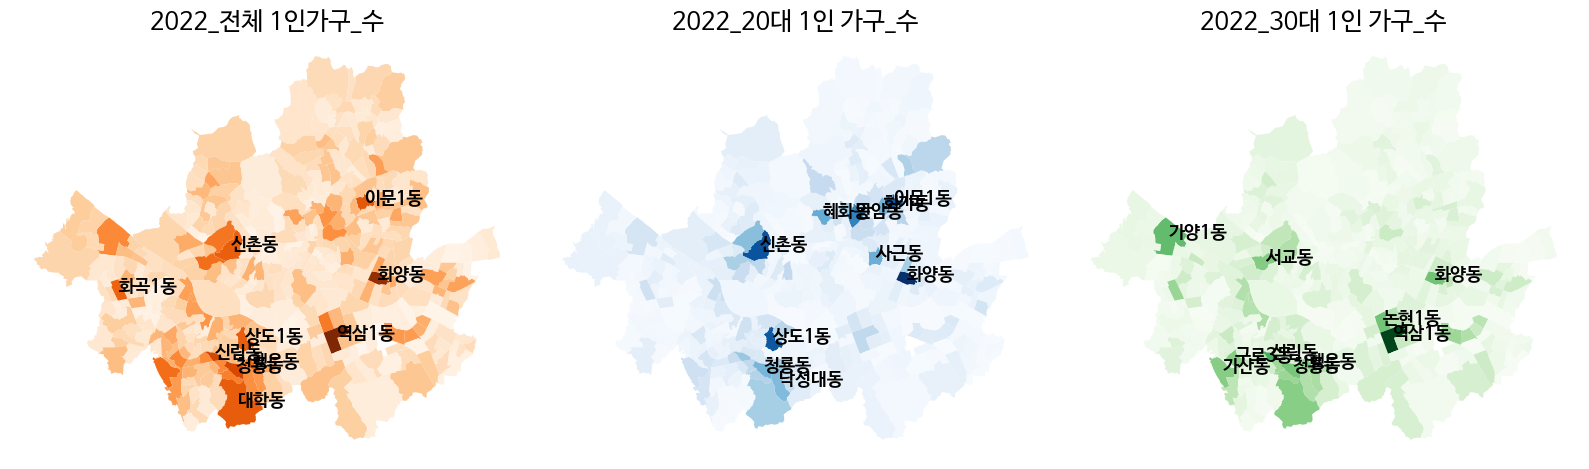

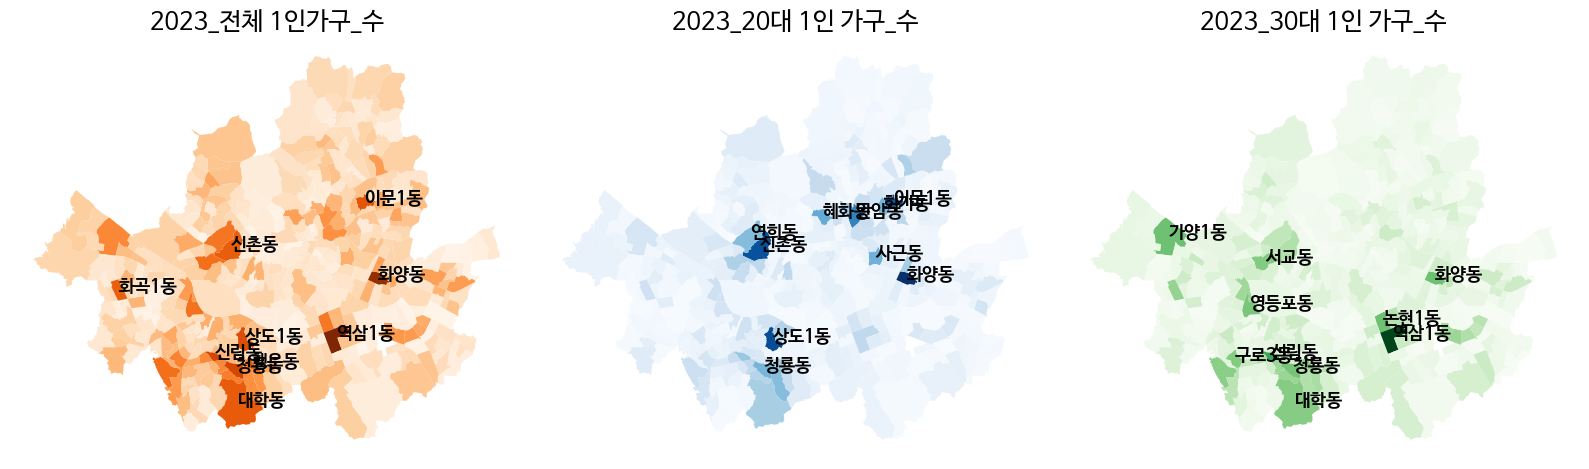

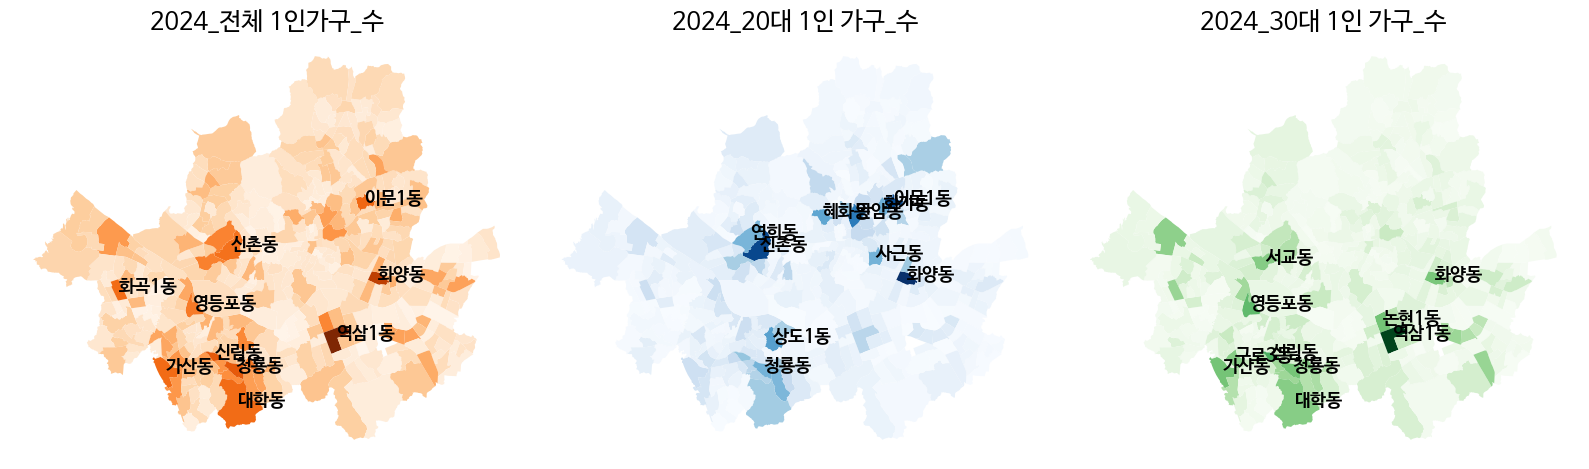

In [16]:
# 1인가구 수 그래프 그리기
# 년도별 / 각 연령대별

for year in year_list:
    map_base = globals()[f'map_base_{year}']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    for i, cnt in enumerate(cnt_list):
    # 그래프 그리기
        map_base.plot(column=cnt, ax=axes[i], cmap=cmap_list[i])
        axes[i].set_title(f'{year}_{ratio_colname[i]}_수', fontsize=18)
        axes[i].axis('off')

        # 상위 10개 지역 표시
        top_10 = map_base.nlargest(10, cnt)
        for idx in range(len(top_10)):
            lat = top_10.geometry.centroid.x.iloc[idx]
            long = top_10.geometry.centroid.y.iloc[idx]
            axes[i].text(lat, long, top_10["ADM_NM"].iloc[idx], fontsize=13, color='black', fontweight='bold')

    plt.tight_layout()

    # 이미지 저장
    plt.savefig(f'{final_img}/{year}년_1인 가구 수.png', format='png')
plt.show()


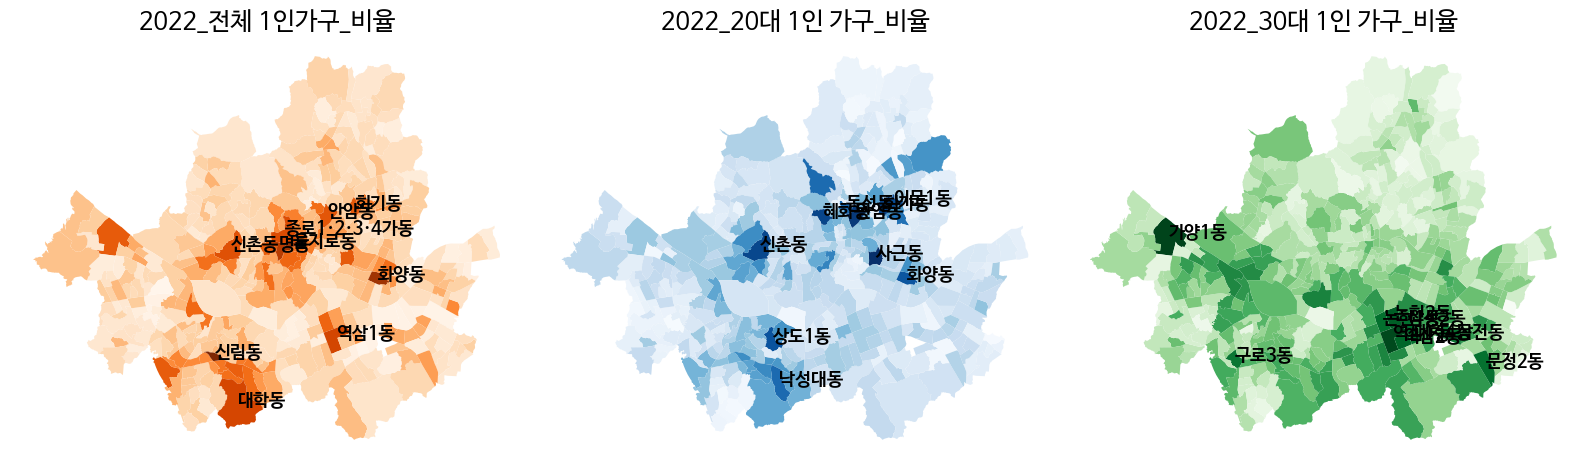

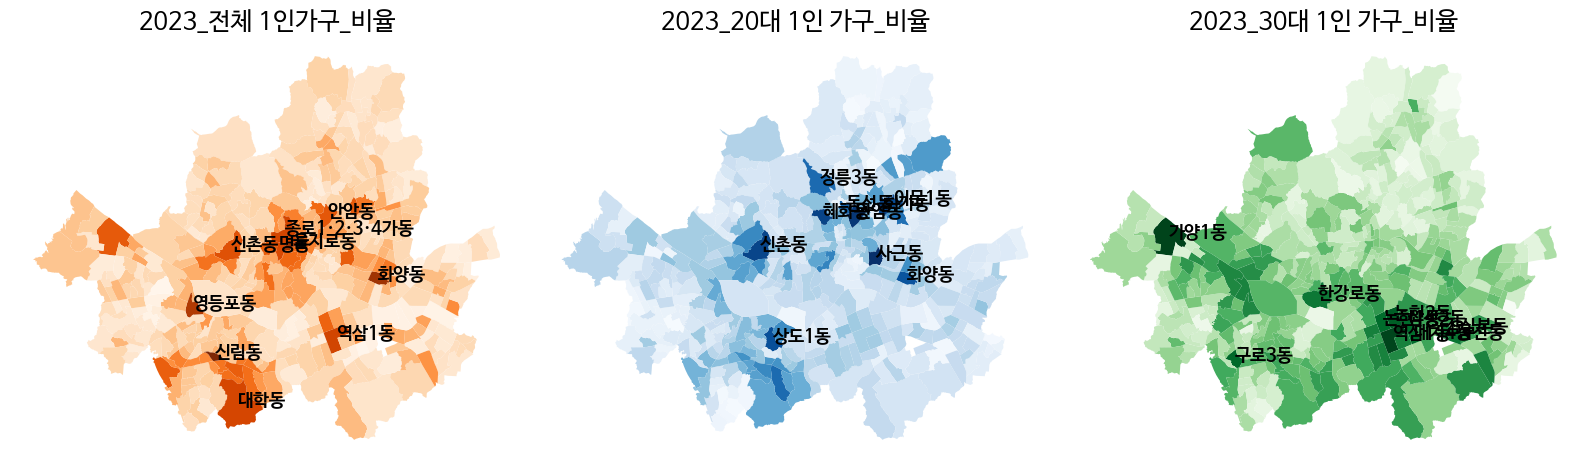

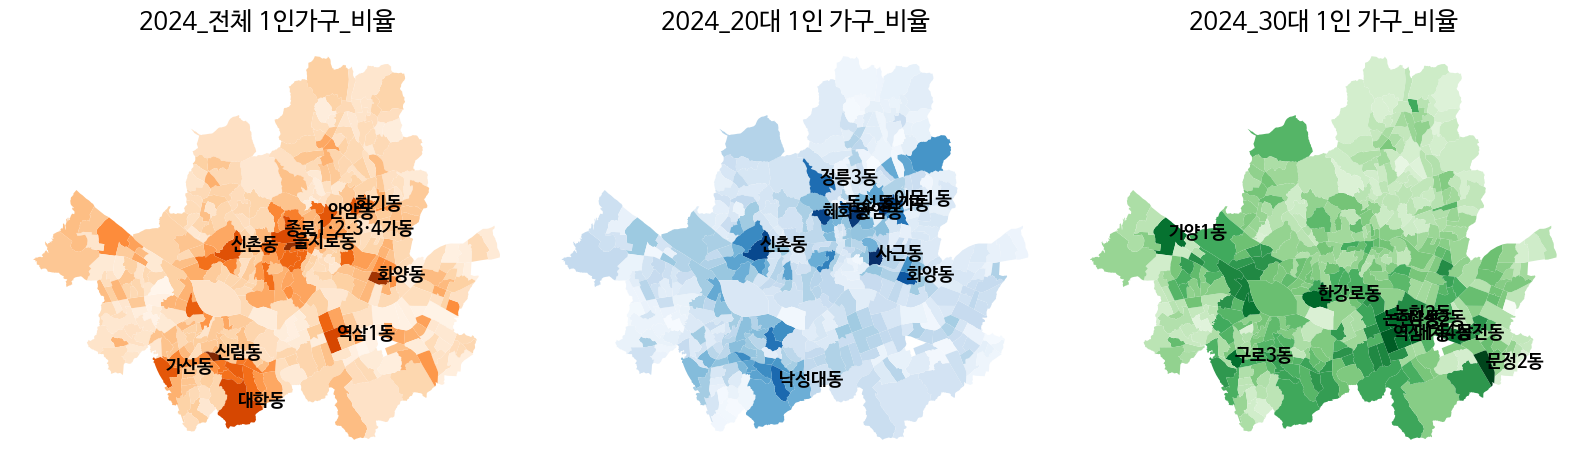

In [17]:
# 1인가구 비율 그래프 그리기
# 년도별 / 각 연령대별

for year in year_list:
    map_base = globals()[f'map_base_{year}']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    for i, ratio in enumerate(ratio_list):
    # 그래프 그리기
        map_base.plot(column=ratio, ax=axes[i], cmap=cmap_list[i])
        axes[i].set_title(f'{year}_{ratio_colname[i]}_비율', fontsize=18)
        axes[i].axis('off')

        # 상위 10개 지역 표시
        top_10 = map_base.nlargest(10, ratio)
        for idx in range(len(top_10)):
            lat = top_10.geometry.centroid.x.iloc[idx]
            long = top_10.geometry.centroid.y.iloc[idx]
            axes[i].text(lat, long, top_10["ADM_NM"].iloc[idx], fontsize=13, color='black', fontweight='bold')

    plt.tight_layout()

    # 이미지 저장
    plt.savefig(f'{final_img}/{year}년_1인 가구 비율.png', format='png')
plt.show()

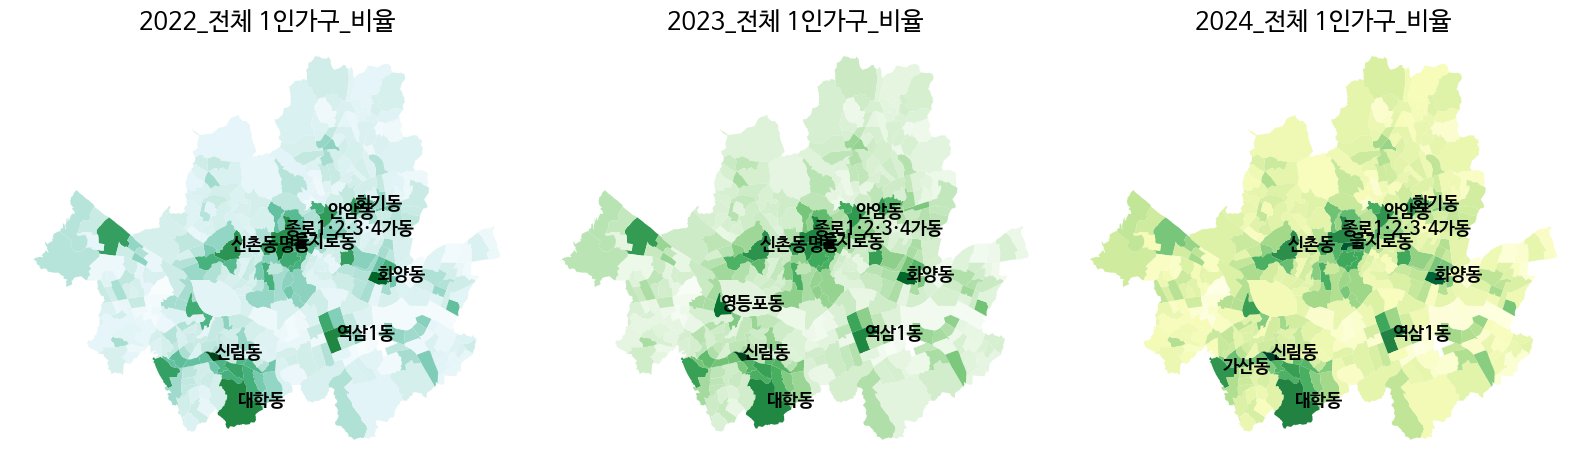

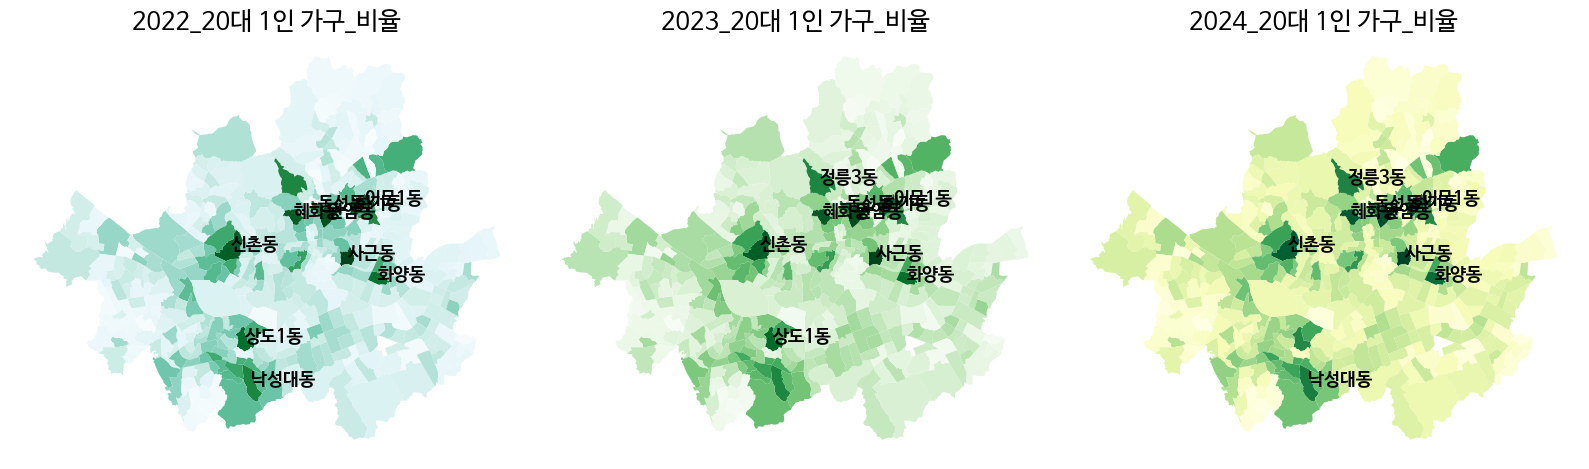

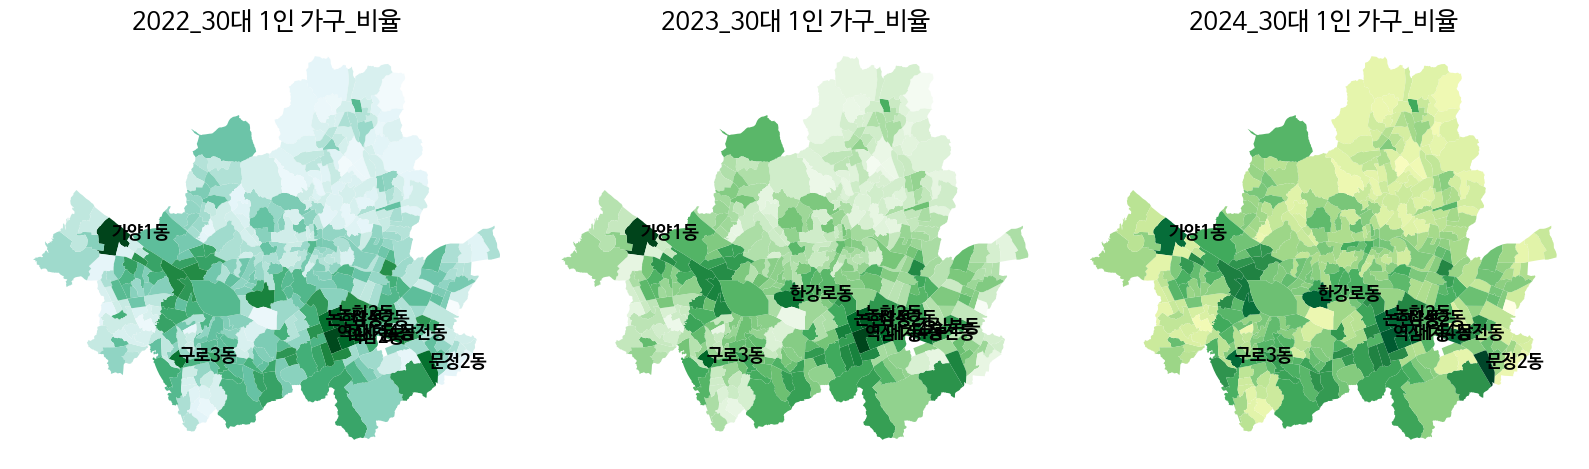

In [18]:
# 1인가구 비율 그래프 그리기
# 각 연령대별 / 년도별

for i_ratio, ratio in enumerate(ratio_list):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    for i_year, year in enumerate(year_list):
        map_base = globals()[f'map_base_{year}']

    # 그래프 그리기
        map_base.plot(column=ratio, ax=axes[i_year], cmap=cmap_year_list[i_year])
        axes[i_year].set_title(f'{year}_{ratio_colname[i_ratio]}_비율', fontsize=18)
        axes[i_year].axis('off')

        # 상위 10개 지역 표시
        top_10 = map_base.nlargest(10, ratio)
        for idx in range(len(top_10)):
            lat = top_10.geometry.centroid.x.iloc[idx]
            long = top_10.geometry.centroid.y.iloc[idx]
            axes[i_year].text(lat, long, top_10["ADM_NM"].iloc[idx], fontsize=13, color='black', fontweight='bold')

    plt.tight_layout()

    # 이미지 저장
    plt.savefig(f'{final_img}/{ratio_colname[i_ratio]}_년도별_1인 가구 비율.png', format='png')
plt.show()

# 지역특성 그래프

In [19]:
region_feature = [ '지가변동률', '사업체수', '대학교',  '월평균소득']

In [20]:
drop_col

['면적', '월평균소득', '총상주인구', '20대상주인구', '총직장인구', '20대직장인구', '유통업체수']

In [21]:
reg_col

['ADM_CD',
 'solo_all_ratio',
 'solo_20s_ratio',
 'solo_30s_ratio',
 '네일숍',
 '미용실',
 '애완동물',
 '분식전문점',
 '한식음식점',
 '양식음식점',
 '일식음식점',
 '중식음식점',
 '치킨전문점',
 '커피-음료',
 '패스트푸드점',
 '제과점',
 '호프-간이주점',
 '대형마트',
 '쇼핑업체수',
 '편의점',
 '슈퍼마켓',
 '사업체수',
 '종사자수',
 '지가변동률',
 '지가',
 '대학교',
 '기타대학']

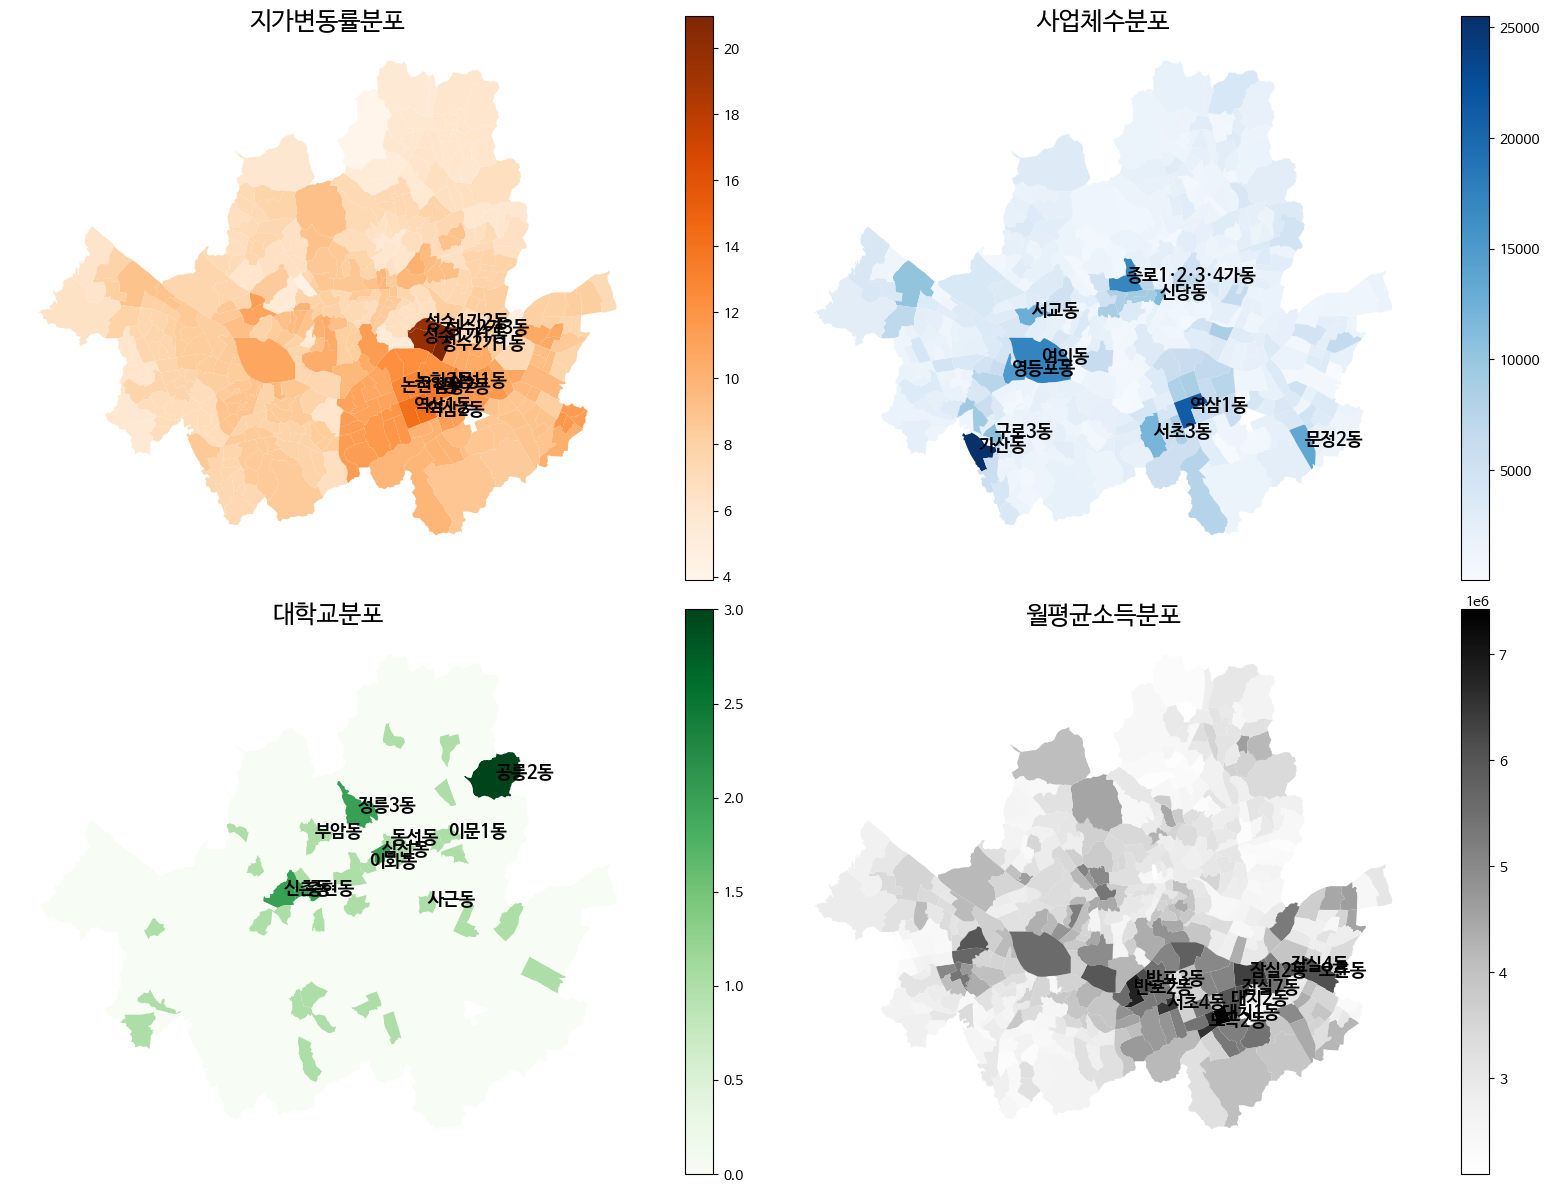

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, var in enumerate(region_feature):
    row = i // 2
    col = i % 2

    # 그래프 그리기
    map_base_2024.plot(column= var, ax=axes[row, col], legend=True, cmap=four_color[i])
    axes[row, col].set_title(var + "분포", fontsize=18)
    axes[row, col].axis('off')

    # 상위 10개 지역 표시
    top_10 = map_base_2024.nlargest(10, var)
    for idx in range(len(top_10)):
        lat = top_10.geometry.centroid.x.iloc[idx]
        long = top_10.geometry.centroid.y.iloc[idx]
        axes[row, col].text(lat, long, top_10["ADM_NM"].iloc[idx], fontsize=13, color='black', fontweight='bold')

plt.tight_layout()

# 이미지 저장
plt.savefig(f'{final_img}/2024_지역특성지도.png', format='png')
plt.show()

In [23]:
map_var = ['지가변동률', '사업체수', '편의점']

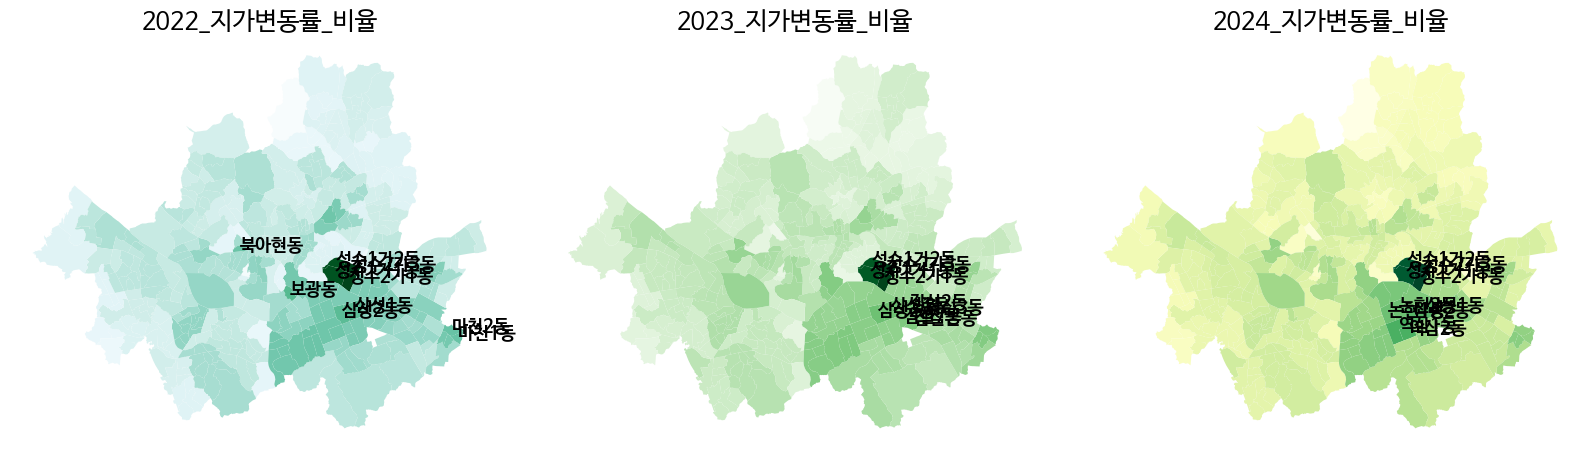

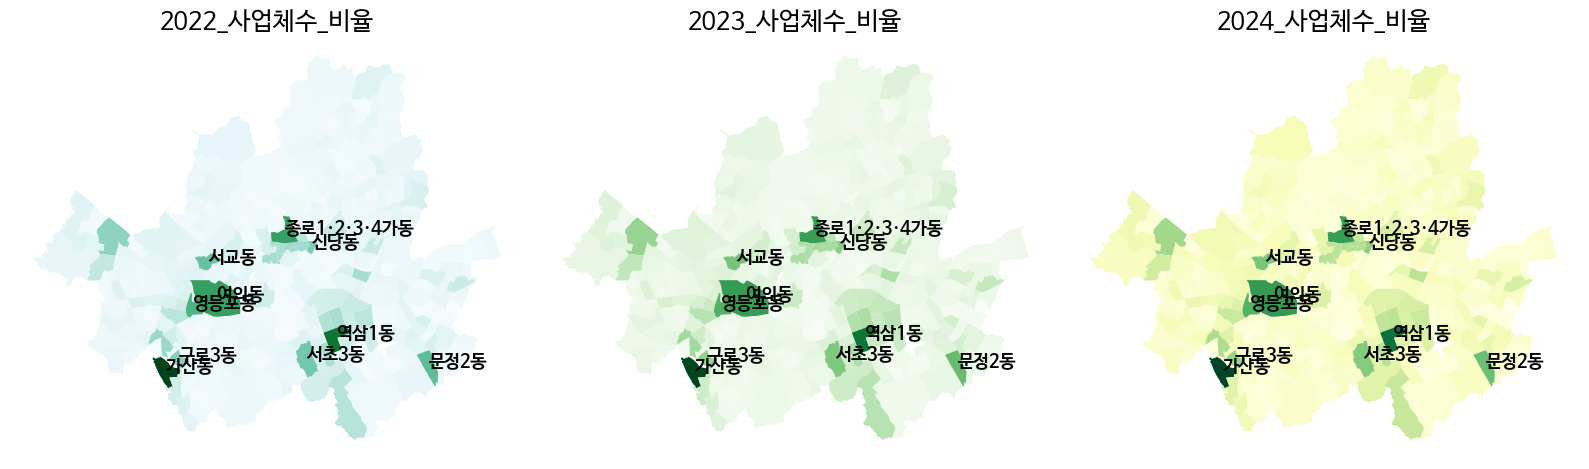

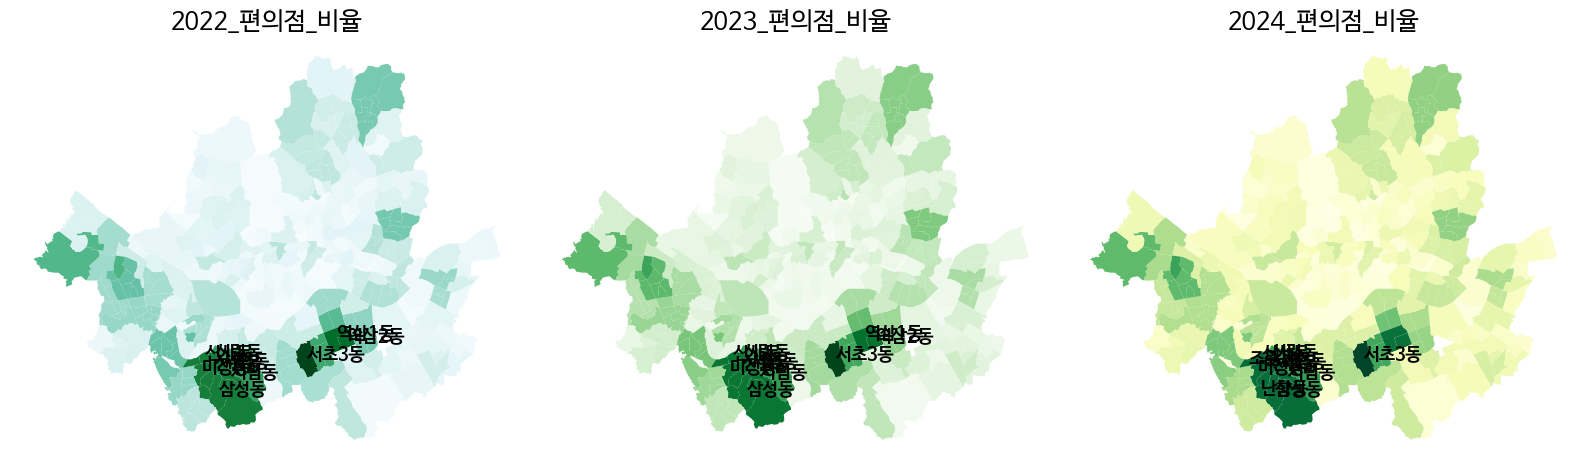

In [24]:
# 지역특성 그래프 그리기
# 년도별

for i_var, var in enumerate(map_var):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    for i_year, year in enumerate(year_list):
        map_base = globals()[f'map_base_{year}']

    # 그래프 그리기
        map_base.plot(column=var, ax=axes[i_year], cmap=cmap_year_list[i_year])
        axes[i_year].set_title(f'{year}_{var}_비율', fontsize=18)
        axes[i_year].axis('off')

        # 상위 10개 지역 표시
        top_10 = map_base.nlargest(10, var)
        for idx in range(len(top_10)):
            lat = top_10.geometry.centroid.x.iloc[idx]
            long = top_10.geometry.centroid.y.iloc[idx]
            axes[i_year].text(lat, long, top_10["ADM_NM"].iloc[idx], fontsize=13, color='black', fontweight='bold')

    plt.tight_layout()

    # 이미지 저장
    plt.savefig(f'{final_img}/{var}_년도별_지역특성.png', format='png')
plt.show()

# 1인가구 상위지역

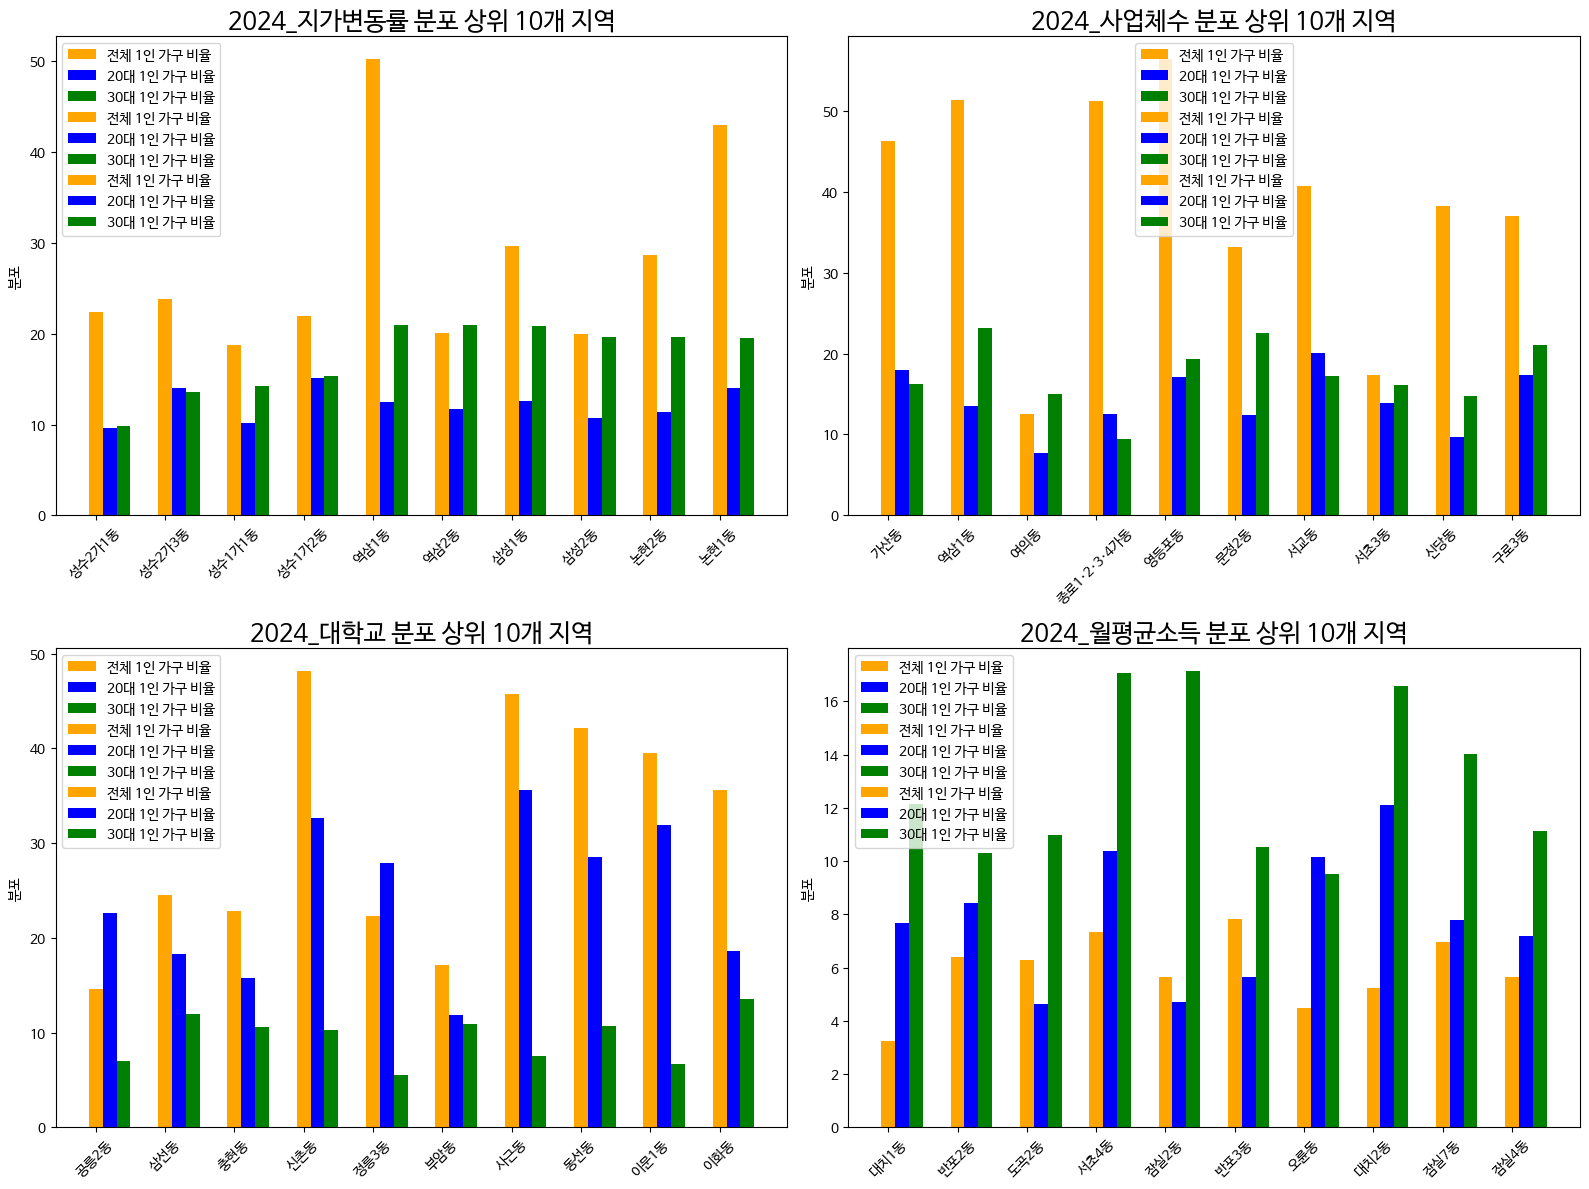

In [25]:
# 1지역특성 상위 10개동 그래프
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for year in year_list:
    df = globals()[f'map_base_{year}']

    for i, var in enumerate(region_feature):
        row = i // 2
        col = i % 2
        data = df.nlargest(10, var)

        bar_width = 0.2
        index = np.arange(len(data['ADM_NM']))

        # axes[row, col].bar(index - bar_width, data['solo_all_ratio'], width=bar_width, color=color_list[0], label='전체 1인가구 비율')
        axes[row, col].bar(index, data['solo_all_ratio'], width=bar_width, color=color_list[0], label='전체 1인 가구 비율')
        axes[row, col].bar(index + bar_width, data['solo_20s_ratio'], width=bar_width, color=color_list[1], label='20대 1인 가구 비율')
        axes[row, col].bar(index + 2 * bar_width, data['solo_30s_ratio'], width=bar_width, color=color_list[2], label='30대 1인 가구 비율')

        axes[row, col].set_title(f"{year}_{var} 분포 상위 10개 지역", fontsize=18)
        axes[row, col].set_ylabel("분포")
        axes[row, col].set_xticks(index)
        axes[row, col].set_xticklabels(data['ADM_NM'], rotation=45)
        axes[row, col].legend()

    # plt.suptitle('1인가구 비율', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'{final_img}/{year}_지역 특성.png', format='png')

plt.show()

In [26]:
data

BASE_DATE ADM_NM    ADM_CD  \
74   20230701   대치1동  11230600   
359  20230701   반포2동  11220580   
372  20230701   도곡2동  11230670   
334  20230701   서초4동  11220540   
199  20230701   잠실2동  11240790   
360  20230701   반포3동  11220590   
125  20230701    오륜동  11240590   
386  20230701   대치2동  11230790   
194  20230701   잠실7동  11240780   
183  20230701   잠실4동  11240750   

                                              geometry  total_all  solo_all  \
74   POLYGON ((961181.399 1944459.061, 961195.337 1...    15702.0     510.0   
359  POLYGON ((955939.986 1945136.286, 955955.333 1...    14556.0     929.0   
372  POLYGON ((960688.264 1943637.313, 960697.015 1...    26263.0    1648.0   
334  POLYGON ((958026.017 1944983.909, 958036.371 1...    22596.0    1634.0   
199  POLYGON ((963659.369 1947108.968, 963660.877 1...    25624.0    1451.0   
360  POLYGON ((956542.140 1946426.039, 956545.030 1...    16169.0    1267.0   
125  POLYGON ((968048.699 1946730.859, 968053.121 1...    14496.0     650.0   
386  POLYGON ((962183.968 1944609.707, 962183.933 1...    31516.0    1655.0   
194  POLYGON ((962746.203 1945849.361, 962764.399 1...     7985.0     557.0   
183  POLYGON ((965939.631 1946830.716, 965827.825 1...    22640.0    1275.0   

     total_20  solo_20  total_25  solo_25  ...   총매출금액_양식음식점   총매출금액_일식음식점  \
74     1171.0     36.0     806.0     27.0  ...  7.463392e+08  5.321950e+08   
359     822.0     64.0     807.0     72.0  ...  0.000000e+00  0.000000e+00   
372    1827.0     62.0    1823.0     68.0  ...  3.926584e+09  2.050082e+09   
334    1434.0    143.0    1446.0    161.0  ...  4.905527e+09  4.003590e+09   
199    1358.0     53.0    1367.0     63.0  ...  3.602224e+08  6.100217e+08   
360    1042.0     61.0     982.0     64.0  ...  3.627874e+08  2.363561e+08   
125    1648.0     88.0     999.0     44.0  ...  4.415328e+08  0.000000e+00   
386    3051.0    183.0    2398.0    161.0  ...  2.096165e+09  2.411211e+09   
194     575.0     42.0     469.0     39.0  ...  0.000000e+00  0.000000e+00   
183    1430.0     75.0    1836.0     97.0  ...  8.223364e+07  0.000000e+00   

        총매출금액_제과점   총매출금액_중식음식점   총매출금액_치킨전문점   총매출금액_커피-음료  총매출금액_패스트푸드점  \
74   1.942699e+09  1.211017e+09  2.597913e+08  3.154412e+09  6.881389e+08   
359  1.094031e+08  0.000000e+00  0.000000e+00  2.820239e+08  0.000000e+00   
372  1.686447e+09  4.154877e+08  2.126387e+08  3.581236e+09  4.763348e+07   
334  8.873646e+08  1.258636e+09  7.821538e+08  5.508323e+09  5.992186e+08   
199  8.498437e+08  0.000000e+00  8.115974e+07  1.957601e+09  2.265353e+08   
360  4.435270e+08  2.496861e+08  1.216158e+09  5.095137e+08  3.087964e+07   
125  0.000000e+00  0.000000e+00  0.000000e+00  4.151766e+08  0.000000e+00   
386  8.726970e+08  3.071952e+09  1.059148e+09  5.312048e+09  1.400652e+09   
194  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
183  1.110000e+08  0.000000e+00  5.708211e+07  3.678124e+07  0.000000e+00   

        총매출금액_편의점   총매출금액_한식음식점  총매출금액_호프-간이주점  
74   1.279862e+09  4.040514e+09   0.000000e+00  
359  1.557324e+09  6.196525e+08   0.000000e+00  
372  2.993438e+09  1.083592e+10   1.350182e+09  
334  7.047053e+09  2.441597e+10   1.036013e+10  
199  9.061328e+08  1.715033e+09   0.000000e+00  
360  5.396210e+08  5.530636e+09   0.000000e+00  
125  1.727652e+09  7.411374e+08   0.000000e+00  
386  8.075110e+09  2.067731e+10   2.933899e+09  
194  3.410978e+08  6.600000e+07   0.000000e+00  
183  2.819361e+09  1.482266e+08   0.000000e+00  

[10 rows x 136 columns]

In [27]:
top_result = pd.DataFrame()
top10_result = pd.DataFrame()
top10_col = []

for year in year_list:
    df = globals()[f'df_{year}']

    for idx, depend in enumerate(ratio_list):
        temp = df.nlargest(10, depend)
        temp_sum = temp[reg_col].sum()
        temp_dong =pd.DataFrame(temp_sum)
        temp_dong.columns = [depend]

        if depend == 'solo_all_ratio':
            top_result = temp_dong
        else:
            top_result = pd.concat([top_result, temp_dong], axis = 1)

        globals()[f'top10_{depend}']= temp

        temp_sum = temp[reg_col].mean().round()

        temp_sum =pd.DataFrame(temp_sum)
        temp_sum.columns = [depend]

        if (year == year_list[0]) & (idx == 0):
            top10_result = temp_sum
        else:
            top10_result = pd.concat([top10_result, temp_sum], axis = 1)

        top10_col.append(f'{year}_{depend[5:8]}')

top10_result.columns = top10_col
top10_result

2022_all    2022_20s    2022_30s    2023_all    2023_20s  \
ADM_CD          11102641.0  11092670.0  11219607.0  11115644.0  11079676.0   
solo_all_ratio        53.0        43.0        33.0        54.0        42.0   
solo_20s_ratio        22.0        32.0        13.0        21.0        32.0   
solo_30s_ratio        12.0         9.0        21.0        13.0         8.0   
네일숍                   33.0        24.0        62.0        36.0        20.0   
미용실                  158.0       124.0       199.0       159.0        91.0   
애완동물                  30.0        18.0        56.0        34.0        14.0   
분식전문점                148.0        71.0       143.0       146.0        52.0   
한식음식점                660.0       310.0       806.0       698.0       233.0   
양식음식점                184.0        90.0       260.0       183.0        66.0   
일식음식점                 81.0        39.0       121.0        87.0        29.0   
중식음식점                 56.0        29.0        75.0        58.0        24.0   
치킨전문점                 22.0        17.0        25.0        20.0        15.0   
커피-음료                 22.0        15.0        15.0        22.0        12.0   
패스트푸드점                34.0        17.0        60.0        33.0        14.0   
제과점                   33.0        22.0        50.0        38.0        17.0   
호프-간이주점               34.0        27.0        15.0        35.0        20.0   
대형마트                   0.0         0.0         0.0         0.0         0.0   
쇼핑업체수                  2.0         1.0         1.0         3.0         1.0   
편의점                   66.0        35.0        88.0        73.0        27.0   
슈퍼마켓                   0.0         0.0         0.0         0.0         0.0   
사업체수                7170.0      2388.0      9362.0      8535.0      2291.0   
종사자수               52307.0     13399.0     70676.0     55421.0     13080.0   
지가변동률                  5.0         5.0         6.0         7.0         7.0   
지가                    97.0        98.0        95.0        99.0        99.0   
대학교                    1.0         1.0         0.0         0.0         1.0   
기타대학                   0.0         0.0         0.0         0.0         0.0   

                  2023_30s    2024_all    2024_20s    2024_30s  
ADM_CD          11199617.0  11118637.0  11080681.0  11199615.0  
solo_all_ratio        35.0        52.0        42.0        33.0  
solo_20s_ratio        13.0        22.0        31.0        12.0  
solo_30s_ratio        21.0        13.0         9.0        20.0  
네일숍                   58.0        40.0        26.0        62.0  
미용실                  179.0       154.0       115.0       183.0  
애완동물                  51.0        34.0        19.0        56.0  
분식전문점                120.0       124.0        60.0       117.0  
한식음식점                697.0       652.0       296.0       709.0  
양식음식점                222.0       164.0        81.0       224.0  
일식음식점                107.0        83.0        41.0       117.0  
중식음식점                 67.0        61.0        31.0        71.0  
치킨전문점                 21.0        18.0        15.0        20.0  
커피-음료                 12.0        16.0        12.0        11.0  
패스트푸드점                47.0        28.0        15.0        43.0  
제과점                   47.0        33.0        20.0        45.0  
호프-간이주점               15.0        32.0        22.0        15.0  
대형마트                   0.0         0.0         0.0         0.0  
쇼핑업체수                  2.0         2.0         1.0         2.0  
편의점                   73.0        75.0        37.0        77.0  
슈퍼마켓                   1.0         0.0         0.0         1.0  
사업체수                8456.0      8875.0      2228.0      9386.0  
종사자수               63781.0     59693.0     13006.0     71586.0  
지가변동률                  9.0         8.0         7.0        11.0  
지가                    98.0       100.0       100.0       100.0  
대학교                    0.0         1.0         1.0         0.0  
기타대학                   0.0         0.0         0.0         0.0

In [28]:
top10_collist = top10_result.columns.tolist()

for select in year_list + depend_name:
    temp = top10_result[[column for column in top10_collist if select in column]]
    temp.to_excel(f'{final_table}/top10_{select}.xlsx')
    temp.to_csv(f'{final_table}/top10_{select}.csv')



In [29]:
top10_nm = []
for year in year_list:
    df = globals()[f'map_base_{year}']

    for depend in ratio_list:
        temp = df.nlargest(10, depend)

        top10_nm.append({'var' : f'{year}_{depend}',
                         'dong0' : temp['ADM_NM'].tolist()[0],
                         'dong1' : temp['ADM_NM'].tolist()[1],
                         'dong2' : temp['ADM_NM'].tolist()[2],
                         'dong3' : temp['ADM_NM'].tolist()[3],
                         'dong4' : temp['ADM_NM'].tolist()[4],
                         'dong5' : temp['ADM_NM'].tolist()[5],
                         'dong6' : temp['ADM_NM'].tolist()[6],
                         'dong7' : temp['ADM_NM'].tolist()[7],
                         'dong8' : temp['ADM_NM'].tolist()[8],
                         'dong9' : temp['ADM_NM'].tolist()[9]})


In [30]:
top10_dong = pd.DataFrame(top10_nm)


top10_dong.to_excel(f'{final_table}/top10_dong.xlsx')
top10_dong.to_csv(f'{final_table}/top10_dong.csv')

# 변수간의 상관관계

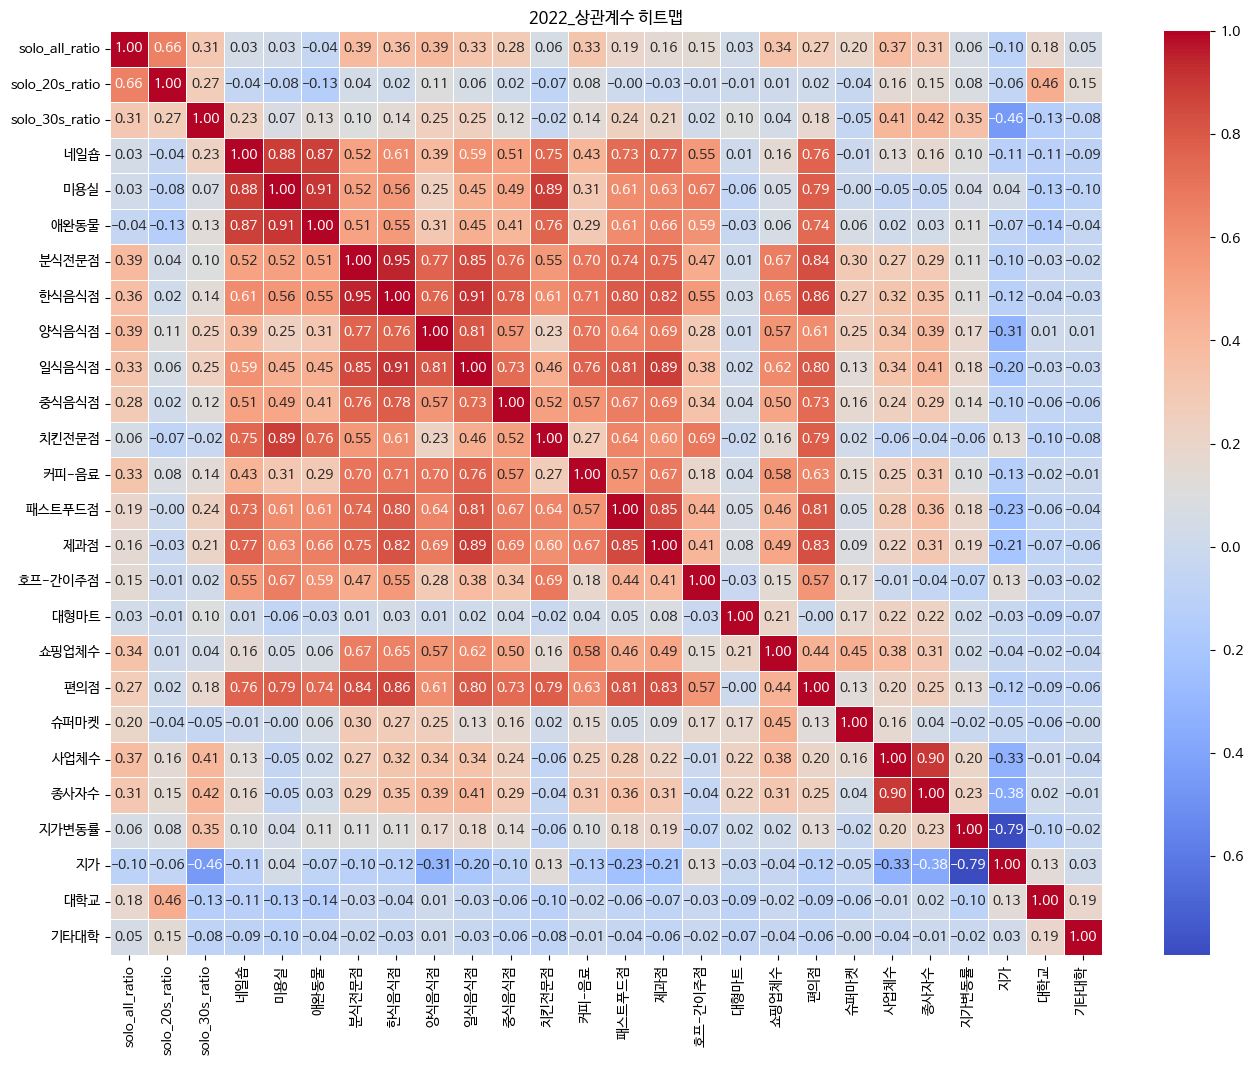

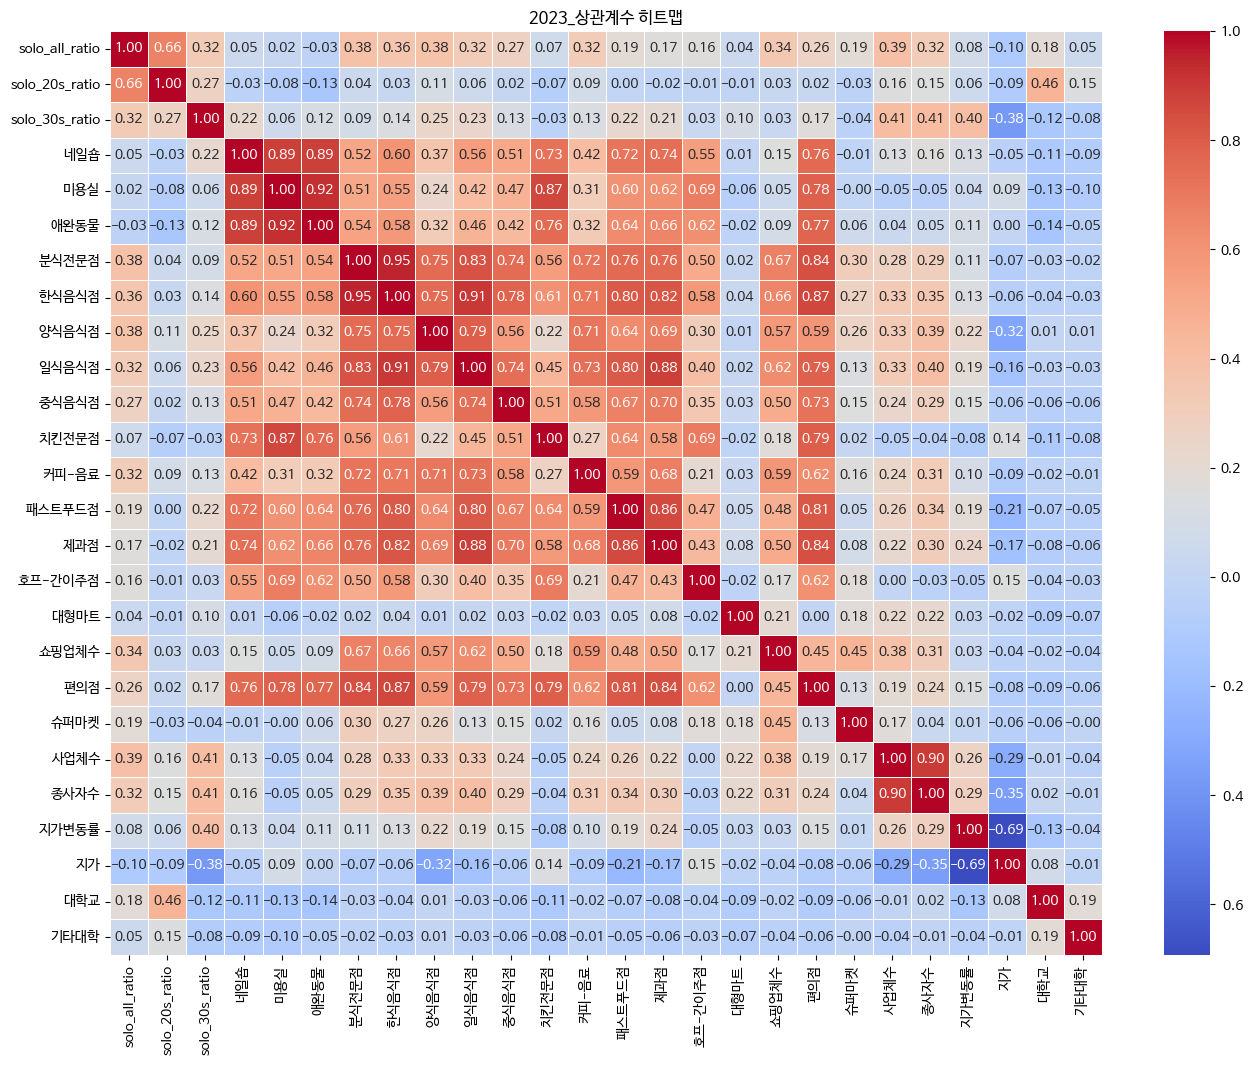

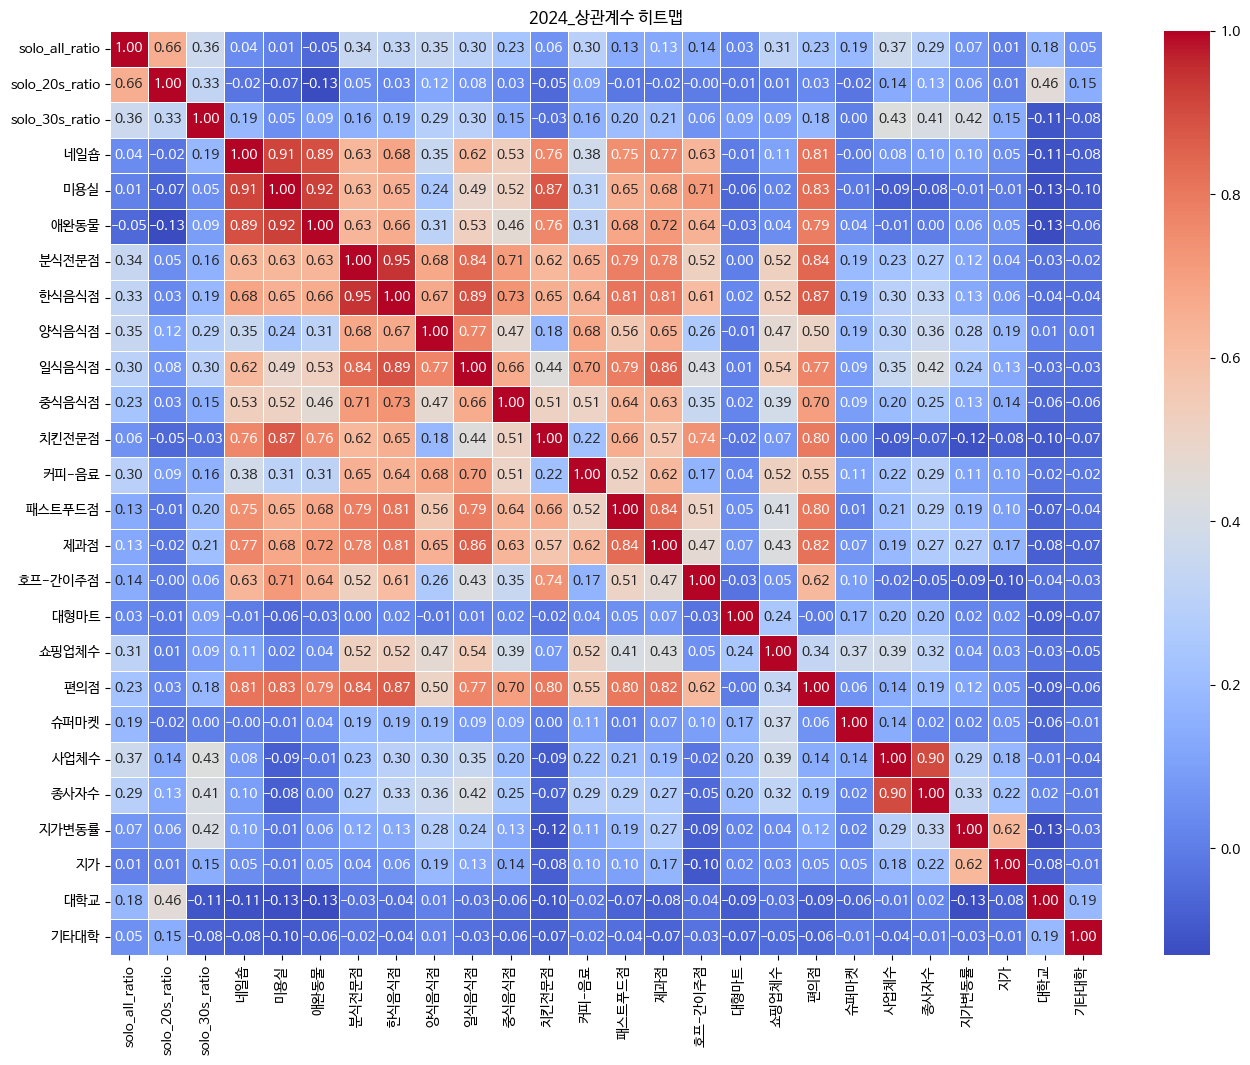

In [31]:
for year in year_list:
    temp = globals()[f'reg_{year}'].drop(columns = 'ADM_CD')
    temp_corr = temp.corr(numeric_only = True)

    # 히트맵 그리기
    plt.figure(figsize=(16, 12))
    sns.heatmap(temp_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"{year}_상관계수 히트맵")
    plt.savefig(f'{final_img}/{year}_상관관계.png', format='png')
    plt.show()
